# Why?

* Sklearn Pipelines are awesome... 

```python
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

...

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(data.data, data.target)


```
http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

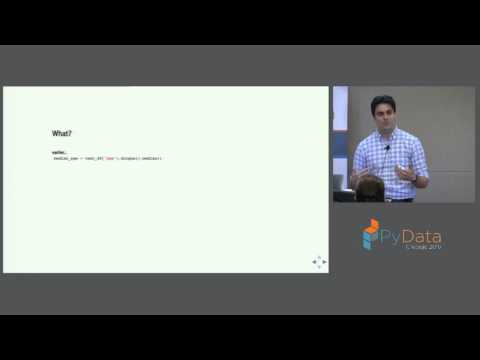

In [1]:
from IPython.display import YouTubeVideo, HTML
YouTubeVideo("URdnFlZnlaE", width=600,height=400)

* ... but sometimes not enough
 * wrapping keras/pytorch models in transformers is tricky
 * caching/saving intermediate outputs is not easy
 * it has to be X,y input

* Airflow does it all but is just to much

<img src="https://airflow.apache.org/_images/airflow.gif" style="width: 800px;"/>


https://airflow.apache.org/

# Why not build one?

<img src="http://bonkersworld.net/img/2011.11.15_building_software.png" style="width: 800px;"/>

## Transformer

* Almost like sklearn transformers
* Every transformer has `fit_transform` and `transform`

```python
def fit_transform(self, X, y):
    return

def transform(self, X):
    return
```

* Those methods return `dict`
* Inputs can be named **however** you like and can be **whatever** you like
* Every transformer implements `save` and `load` methods

```python
from keras.models import load_model

def save(self, filepath):
    self.model.save(filepath)

def load(self, filepath):
    self.model = load_model(filepath)
    return self
```

* They can do much **more than** just **transform data**.

In [2]:
%load_ext autoreload
%autoreload 2

from steps.preprocessing import TextCounter

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jakub.czakon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jakub.czakon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
text_counter = TextCounter()

outputs = text_counter.fit_transform(['calculate featueres for this text',
                                       'Get Some Features For This As Well !!!'])


In [4]:
for key, output in outputs.items():
    display(key)
    display(output)

'X'

,char_count,digit_count,lower_case_count,newline_count,punctuation_count,space_count,upper_case_count,word_count,caps_vs_length,num_symbols,num_words,num_unique_words,words_vs_unique,mean_word_len
0,33,0,29,0,0,4,0,5,0.000000,0,5,5,1.0,5.800
1,38,0,21,0,3,7,7,8,0.184211,0,8,8,1.0,3.875


In [ ]:
# %load steps/keras/models.py
import shutil

from keras.models import load_model

from ..base import BaseTransformer
from .contrib import AttentionWeightedAverage
from .architectures import vdcnn, scnn, dpcnn, cudnn_gru, cudnn_lstm


class KerasModelTransformer(BaseTransformer):
    """
    Todo:
        load the best model at the end of the fit and save it
    """

    def __init__(self, architecture_config, training_config, callbacks_config):
        self.architecture_config = architecture_config
        self.training_config = training_config
        self.callbacks_config = callbacks_config

    def reset(self):
        self.model = self._build_model(**self.architecture_config)

    def _compile_model(self, model_params, optimizer_params):
        model = self._build_model(**model_params)
        optimizer = self._build_optimizer(**optimizer_params)
        loss = self._build_loss()
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def _create_callbacks(self, **kwargs):
        return NotImplementedError

    def _build_model(self, **kwargs):
        return NotImplementedError

    def _build_optimizer(self, **kwargs):
        return NotImplementedError

    def _build_loss(self, **kwargs):
        return NotImplementedError

    def save(self, filepath):
        checkpoint_callback = self.callbacks_config.get('model_checkpoint')
        if checkpoint_callback:
            checkpoint_filepath = checkpoint_callback['filepath']
            shutil.copyfile(checkpoint_filepath, filepath)
        else:
            self.model.save(filepath)

    def load(self, filepath):
        self.model = load_model(filepath,
                                custom_objects={'AttentionWeightedAverage': AttentionWeightedAverage})
        return self


class ClassifierXY(KerasModelTransformer):
    def fit(self, X, y, validation_data, *args, **kwargs):
        self.callbacks = self._create_callbacks(**self.callbacks_config)
        self.model = self._compile_model(**self.architecture_config)

        self.model.fit(X, y,
                       validation_data=validation_data,
                       callbacks=self.callbacks,
                       verbose=1,
                       **self.training_config)
        return self

    def transform(self, X, y=None, validation_data=None, *args, **kwargs):
        predictions = self.model.predict(X, verbose=1)
        return {'prediction_probability': predictions}


class ClassifierGenerator(KerasModelTransformer):
    def fit(self, datagen, validation_datagen, *args, **kwargs):
        self.callbacks = self._create_callbacks(**self.callbacks_config)
        self.model = self._compile_model(**self.architecture_config)

        train_flow, train_steps = datagen
        valid_flow, valid_steps = validation_datagen
        self.model.fit_generator(train_flow,
                                 steps_per_epoch=train_steps,
                                 validation_data=valid_flow,
                                 validation_steps=valid_steps,
                                 callbacks=self.callbacks,
                                 verbose=1,
                                 **self.training_config)
        return self

    def transform(self, datagen, validation_datagen=None, *args, **kwargs):
        test_flow, test_steps = datagen
        predictions = self.model.predict_generator(test_flow, test_steps, verbose=1)
        return {'prediction_probability': predictions}


class PretrainedEmbeddingModel(ClassifierXY):
    def fit(self, X, y, validation_data, embedding_matrix):
        X_valid, y_valid = validation_data
        self.callbacks = self._create_callbacks(**self.callbacks_config)
        self.architecture_config['model_params']['embedding_matrix'] = embedding_matrix
        self.model = self._compile_model(**self.architecture_config)
        self.model.fit(X, y,
                       validation_data=[X_valid, y_valid],
                       callbacks=self.callbacks,
                       verbose=1,
                       **self.training_config)
        return self

    def transform(self, X, y=None, validation_data=None, embedding_matrix=None):
        predictions = self.model.predict(X, verbose=1)
        return {'prediction_probability': predictions}


class CharVDCNNTransformer(ClassifierXY):
    def _build_model(self, embedding_size, maxlen, max_features,
                     filter_nr, kernel_size, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, conv_dropout, dense_dropout, dropout_mode,
                     conv_kernel_reg_l2, conv_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first):
        return vdcnn(embedding_size, maxlen, max_features,
                     filter_nr, kernel_size, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, conv_dropout, dense_dropout, dropout_mode,
                     conv_kernel_reg_l2, conv_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first)


class WordSCNNTransformer(PretrainedEmbeddingModel):
    def _build_model(self, embedding_matrix, embedding_size, trainable_embedding, maxlen, max_features,
                     filter_nr, kernel_size, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, conv_dropout, dense_dropout, dropout_mode,
                     conv_kernel_reg_l2, conv_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first):
        return scnn(embedding_matrix, embedding_size, trainable_embedding, maxlen, max_features,
                    filter_nr, kernel_size, repeat_block,
                    dense_size, repeat_dense, output_size, output_activation,
                    max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                    dropout_embedding, conv_dropout, dense_dropout, dropout_mode,
                    conv_kernel_reg_l2, conv_bias_reg_l2,
                    dense_kernel_reg_l2, dense_bias_reg_l2,
                    use_prelu, use_batch_norm, batch_norm_first)


class WordDPCNNTransformer(PretrainedEmbeddingModel):
    def _build_model(self, embedding_matrix, embedding_size, trainable_embedding, maxlen, max_features,
                     filter_nr, kernel_size, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, conv_dropout, dense_dropout, dropout_mode,
                     conv_kernel_reg_l2, conv_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first):
        """
        Implementation of http://ai.tencent.com/ailab/media/publications/ACL3-Brady.pdf
        """
        return dpcnn(embedding_matrix, embedding_size, trainable_embedding, maxlen, max_features,
                     filter_nr, kernel_size, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, conv_dropout, dense_dropout, dropout_mode,
                     conv_kernel_reg_l2, conv_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first)


class WordCuDNNLSTMTransformer(PretrainedEmbeddingModel):
    def _build_model(self, embedding_matrix, embedding_size, trainable_embedding,
                     maxlen, max_features,
                     unit_nr, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, rnn_dropout, dense_dropout, dropout_mode,
                     rnn_kernel_reg_l2, rnn_recurrent_reg_l2, rnn_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first):
        return cudnn_lstm(embedding_matrix, embedding_size, trainable_embedding,
                          maxlen, max_features,
                          unit_nr, repeat_block,
                          dense_size, repeat_dense, output_size, output_activation,
                          max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                          dropout_embedding, rnn_dropout, dense_dropout, dropout_mode,
                          rnn_kernel_reg_l2, rnn_recurrent_reg_l2, rnn_bias_reg_l2,
                          dense_kernel_reg_l2, dense_bias_reg_l2,
                          use_prelu, use_batch_norm, batch_norm_first)


class WordCuDNNGRUTransformer(PretrainedEmbeddingModel):
    def _build_model(self, embedding_matrix, embedding_size, trainable_embedding,
                     maxlen, max_features,
                     unit_nr, repeat_block,
                     dense_size, repeat_dense, output_size, output_activation,
                     max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                     dropout_embedding, rnn_dropout, dense_dropout, dropout_mode,
                     rnn_kernel_reg_l2, rnn_recurrent_reg_l2, rnn_bias_reg_l2,
                     dense_kernel_reg_l2, dense_bias_reg_l2,
                     use_prelu, use_batch_norm, batch_norm_first):
        return cudnn_gru(embedding_matrix, embedding_size, trainable_embedding,
                         maxlen, max_features,
                         unit_nr, repeat_block,
                         dense_size, repeat_dense, output_size, output_activation,
                         max_pooling, mean_pooling, weighted_average_attention, concat_mode,
                         dropout_embedding, rnn_dropout, dense_dropout, dropout_mode,
                         rnn_kernel_reg_l2, rnn_recurrent_reg_l2, rnn_bias_reg_l2,
                         dense_kernel_reg_l2, dense_bias_reg_l2,
                         use_prelu, use_batch_norm, batch_norm_first)


## Step

```python
glove_dpcnn = Step(name='glove_dpcnn',
                   transformer=WordDPCNN(**config.dpcnn_network),
                   input_data = [],
                   input_steps=[word_tokenizer, 
                                preprocessed_input,      
                                glove_embeddings],
                   adapter={'X': ([('word_tokenizer', 'X')]),
                            'y': ([('cleaning_output', 'y')]),
                            'embedding_matrix': ([('glove_embeddings', 'embeddings_matrix')]),
                            'validation_data': (
                                [('word_tokenizer', 'X_valid'), ('cleaning_output', 'y_valid')],
                                to_tuple_inputs),
                            },
                   cache_dirpath=config.env.cache_dirpath,
                   cache_output = True,
                   save_output=False, 
                   load_saved_output=False,
                   force_fitting=True
                  )
```

* Building block of pipelines
* Wraps around transformer and adds functionality
* easy to plug in outputs from other steps and data sources with `input_steps`, `input_data` and `adapter`
* transformers are cached/persisted as the pipeline trains (not only after it has trained)
* outputs are cached by default but you can save outputs for debugging/inspection with `save_output`
* if you want to always fit step even if it was fit before use `force_fitting`
* objects are stored in the `cache_dirpath` folder

In [7]:
! ls /mnt/ml-team/dsb_2018/kuba/trained_pipelines/weighted_loss

checkpoints  outputs  submission.csv  tmp  transformers


## Pipeline

DAG of steps

In [12]:
from steps.base import Step
from steps.preprocessing import XYSplit, TextCleaner
from steps.keras.loaders import Tokenizer
from steps.keras.embeddings import GloveEmbeddingsMatrix
from steps.keras.models import WordDPCNNTransformer

In [13]:
CACHE_DIR = '/mnt/ml-team/minerva/debug/ml_seminar'

xy_train = Step(name='xy_train',
            transformer=XYSplit(x_columns=['comment_text'],
                                y_columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
                               ),
            input_data=['input'],
            adapter={'meta': ([('input', 'meta')]),
                     'train_mode': ([('input', 'train_mode')])
                     },
            cache_dirpath=CACHE_DIR)

text_cleaner = Step(name='text_cleaner_train',
                transformer=TextCleaner(drop_punctuation=True,
                                        drop_newline=True,
                                        drop_multispaces=True,
                                        all_lower_case=True,
                                        fill_na_with='',
                                        deduplication_threshold=10,
                                        anonymize=False,
                                        apostrophes=False,
                                        use_stopwords=True),
                input_steps=[xy_train],
                adapter={'X': ([('xy_train', 'X')])},
                cache_dirpath=CACHE_DIR)

word_tokenizer = Step(name='word_tokenizer',
                      transformer=Tokenizer(char_level=False,
                                            maxlen=200,
                                            num_words=10000),
                      input_steps=[text_cleaner],
                      adapter={'X': ([(text_cleaner.name, 'X')]),
                               'train_mode': ([('cleaning_output', 'train_mode')])
                               },
                      cache_dirpath=CACHE_DIR)

glove_embeddings = Step(name='glove_embeddings',
                        transformer=GloveEmbeddingsMatrix(pretrained_filepath='glove.840B.300d.txt',
                                                          max_features=10000,
                                                          embedding_size=300),
                        input_steps=[word_tokenizer],
                        adapter={'tokenizer': ([(word_tokenizer.name, 'tokenizer')]),
                                 },
                        cache_dirpath=CACHE_DIR)

In [14]:
import os

dpcnn_config = {
    'architecture_config': {'model_params': {'max_features': 300,
                                             'maxlen': 200,
                                             'embedding_size': 300,
                                             'trainable_embedding': True,
                                             'filter_nr': 64,
                                             'kernel_size': 3,
                                             'repeat_block': 6,
                                             'dense_size': 256,
                                             'repeat_dense': 2,
                                             'output_size': 6,
                                             'output_activation': 'sigmoid',
                                             'max_pooling': True,
                                             'mean_pooling': True,
                                             'weighted_average_attention': False,
                                             'concat_mode': 'concat',
                                             'dropout_embedding': 0.5,
                                             'conv_dropout': 0.25,
                                             'dense_dropout': 0.25,
                                             'dropout_mode': 'spatial',
                                             'conv_kernel_reg_l2': 0.0,
                                             'conv_bias_reg_l2': 0.0,
                                             'dense_kernel_reg_l2': 0.0,
                                             'dense_bias_reg_l2': 0.0,
                                             'use_prelu': True,
                                             'use_batch_norm': True,
                                             'batch_norm_first': True,
                                             },
                            'optimizer_params': {'lr': 0.01,
                                                 'momentum': 0.9,
                                                 'nesterov': True
                                                 },
                            },
    'training_config': {'epochs': 10,
                        'shuffle': True,
                        'batch_size': 128,
                        },
    'callbacks_config': {'model_checkpoint': {
        'filepath': os.path.join(CACHE_DIR, 'checkpoints', 'dpcnn_network', 'best_model.h5'),
        'save_best_only': True,
        'save_weights_only': False},
        'lr_scheduler': {'gamma': 0.95},
        'unfreeze_layers': {'unfreeze_on_epoch': 10},
        'early_stopping': {'patience': 5},
        'neptune_monitor': {'model_name': 'dpcnn'},
    },
}

In [15]:
glove_dpcnn = Step(name='glove_dpcnn',
                   transformer=WordDPCNNTransformer(**dpcnn_config),
                   input_steps=[word_tokenizer, xy_train, glove_embeddings],
                   adapter={'X': ([('word_tokenizer', 'X')]),
                            'y': ([('xy_train', 'y')]),
                            'embedding_matrix': ([('glove_embeddings', 'embeddings_matrix')]),
                            },
                   cache_dirpath=CACHE_DIR)

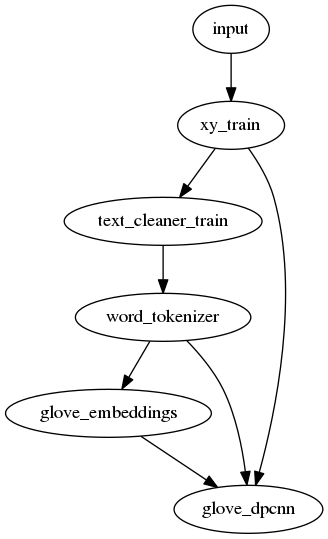

In [16]:
glove_dpcnn

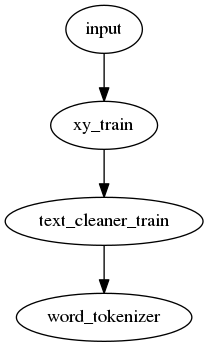

In [17]:
intermediate_step = glove_dpcnn.get_step('word_tokenizer')
intermediate_step

In [18]:
intermediate_step.transformer.__dict__

{'char_level': False,
 'maxlen': 200,
 'num_words': 10000,
 'tokenizer': <keras.preprocessing.text.Tokenizer at 0x7f89c1582a90>}

## Training/Inference

Just run `fit_transform` on last the very last step and all steps will be fitted recursively
```python
    data_train = {'input': {'meta': train,
                            'meta_valid': valid,
                            'train_mode': True,
                      },
            }
    train_predictions = glove_dpcnn.fit_transform(data_train)
```

prediction will be done on `transform`

```python
    data_inference = {'input': {'meta': test,
                                'meta_valid': None,
                                'train_mode': False,
                      },
            }
    train_predictions = glove_dpcnn.transform(data_inference)
```


# What is missing?
* automatic sklean/steps conversion

```python

from steps.base import make_step

step_transformer = make_step(SklearnTransformer())
step_transformer = make_step(Pipeline())
```

* automatic grid search

```python

xgboost_ensemble = Step(name='xgboost_ensemble',
                        transformer=XGBoostClassifierMultilabel(**config.xgboost_ensemble),
                        input_data=['input'],
                        cache_dirpath=CACHE_DIR,
                        grid_search_params=parameter_space,
                        grid_runs=100,
                        grid_search_method='hyperopt')
```

* paralelization
* automatic multistep bagging

# Let's talk toxic
https://github.com/neptune-ml/kaggle-toxic-starter